In [1]:
import numpy as np
from numpy.random import shuffle
import matplotlib.pyplot as plt
import scipy.stats as stats

def gen_gaussian_data(N, dim=2, dist=1, stddev=1.0):
    # generate N random data vectors from two Gaussian clusters
    data = []
    # first cluster is always centered on [0, 0, 0, ...]
    cluster1mean = np.zeros(dim)
    cluster1size = N // 2
    for i in range(cluster1size):
        data.append(np.random.normal(cluster1mean, stddev, (dim)))

    # second cluster is placed along the vector dist*[1, 1, 1, ...]
    cluster2mean = np.zeros(dim) + dist
    for i in range(N-cluster1size):
        data.append(np.random.normal(cluster2mean, stddev, (dim)))
    return np.array(data), cluster1mean, cluster2mean


def plot_data(data):
    fig, ax = plt.subplots(figsize=[4,4])
    ax.scatter(data[:,0], data[:,1])
    ax.axvline(0, ls='--', c='grey')
    ax.axhline(0, ls='--', c='grey')
    plt.show()
    plt.close()

def plot_cluster(data, cluster0, cluster1):
    cluster0 = np.array(cluster0)
    cluster1 = np.array(cluster1)
    fig, ax = plt.subplots(figsize=[4,4])
    ax.scatter(cluster0[:,0], cluster0[:,1], c='r')
    ax.scatter(cluster1[:,0], cluster1[:,1], c='b')
    plt.show()
    plt.close()

In [2]:
from active_coresets.coreset_algorithms import bayesian_inference
from active_coresets.classical_algorithms import RandomSampler
from active_coresets.quantum_algorithms import ClassicalExponentialSampler, VQT
from active_coresets.data_structures import Coreset, Model

from typing import List, Tuple

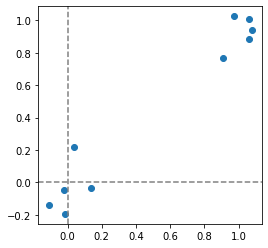

In [3]:
num_data = 10
data, c1, c2 = gen_gaussian_data(num_data, stddev=0.1)
shuffle(data)
plot_data(data)

In [4]:
class ClusteringModel(Model):
    def __init__(self, clusters: Tuple[List[np.ndarray], List[np.ndarray]]):
        self.clusters = clusters
        self.cluster0_center = np.average(clusters[0], axis=0) if len(clusters[0]) > 0 else [0.0, 0.0]
        self.cluster1_center = np.average(clusters[1], axis=0) if len(clusters[1]) > 0 else [0.0, 0.0]
    
    def evaluate_on_coreset(self, coreset: Coreset) -> float:
        total_dist = 0.0
        for data, weight in coreset.coreset:
            if any((data == x).all() for x in self.clusters[0]):
                total_dist += weight * np.linalg.norm(data - self.cluster0_center)
            else:
                total_dist += weight * np.linalg.norm(data - self.cluster1_center)
        return -total_dist
        

In [5]:
Y = []
for model_bitstring in range(2**(num_data)):
    cluster0 = []
    cluster1 = []
    for i in range(num_data):
        if (model_bitstring >> i) & 0x1 == 0:
            cluster0.append(data[i])
        else:
            cluster1.append(data[i])
    Y.append(ClusteringModel((cluster0, cluster1)))

Cost at step 0: -0.6820634544312121
Cost at step 20: -0.7359017443583495
Cost at step 40: -0.8700229189696841
Cost at step 60: -0.9734902536614509
Cost at step 80: -1.288745263056744
Cost at step 100: -1.3227790705967477
Cost at step 120: -1.3728068896292482
Cost at step 140: -1.3846665244954437
Cost at step 160: -1.385868301345338
Cost at step 180: -1.386265257643857
Cost at step 200: -1.3862915162211689
Cost at step 220: -1.386293753612562
Cost at step 240: -1.3862942284279023
Cost at step 260: -1.3862942094728274
Cost at step 280: -1.3862943412941269
Cost at step 300: -1.3862943543148045
 final_simplex: (array([[0.73833262, 1.71453631, 3.20220226, 3.8544461 , 1.83579749,
        0.70917052, 3.7628654 , 0.69321405, 0.69317936],
       [0.73831264, 1.71455204, 3.20222022, 3.85448406, 1.8357944 ,
        0.70916695, 3.76285493, 0.69316165, 0.69320026],
       [0.73832432, 1.71454803, 3.20222516, 3.85443355, 1.83577595,
        0.70916362, 3.76289408, 0.69322093, 0.69320194],
       [0.

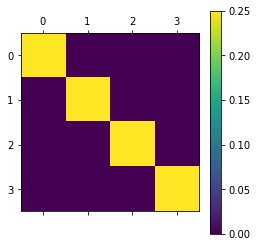

Final Entropy: 1.3862943583662815
Final Expectation Value: -4.1420475338505014e-07
Final Cost: -1.386294362508329
11
1111111111
Cost at step 0: -1.0330014442756525
Cost at step 20: -1.0558832790186317
Cost at step 40: -1.167215098652592
Cost at step 60: -1.4147084005703698
Cost at step 80: -1.3431797305102322
Cost at step 100: -1.4062762135671485
Cost at step 120: -1.418612702253729
Cost at step 140: -1.4402524976169393
Cost at step 160: -1.4816906481009708
Cost at step 180: -1.7268720683721963
Cost at step 200: -1.6286931866226366
Cost at step 220: -1.9810519506806816
Cost at step 240: -2.0479768191726446
Cost at step 260: -2.077698344896139
Cost at step 280: -2.0758273211527283
Cost at step 300: -2.0765310779003276
Cost at step 320: -2.078203037416739
Cost at step 340: -2.0776911581846806
Cost at step 360: -2.078634273514516
Cost at step 380: -2.0788259683995856
Cost at step 400: -2.0790589523761187
Cost at step 420: -2.0792823061167285
Cost at step 440: -2.079387575657706
Cost at st

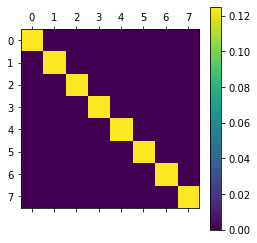

Final Entropy: 2.0794409646738385
Final Expectation Value: -0.00011245011069083155
Final Cost: -2.0794420891749454
001
1011011111
Cost at step 0: -1.4819260672687011
Cost at step 20: -1.5043401534365957
Cost at step 40: -1.5364992577367755
Cost at step 60: -1.6036435470623838
Cost at step 80: -1.6787158837857588
Cost at step 100: -1.6897347716320166
Cost at step 120: -1.7933019899800497
Cost at step 140: -2.0577385427666752
Cost at step 160: -2.427154232037478
Cost at step 180: -2.262930848629384
Cost at step 200: -2.5735428856819675
Cost at step 220: -2.51811473045793
Cost at step 240: -2.7470484924180982
Cost at step 260: -2.65845007768529
Cost at step 280: -2.761491788142274
Cost at step 300: -2.748273600056181
Cost at step 320: -2.756750283569211
Cost at step 340: -2.763683235625064
Cost at step 360: -2.768879842558933
Cost at step 380: -2.768434995741138
Cost at step 400: -2.769094571116421
Cost at step 420: -2.7692269762868507
Cost at step 440: -2.769347026488947
Cost at step 460

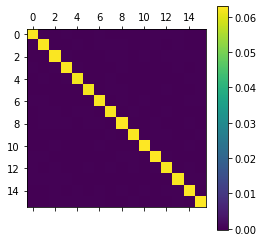

Final Entropy: 2.7725345150860443
Final Expectation Value: -0.0110325537717543
Final Cost: -2.772644840623762
1010
1100110010


In [6]:
A = RandomSampler()
B = VQT(.01)

final_model = bayesian_inference(list(data), Y, 5, A, B)

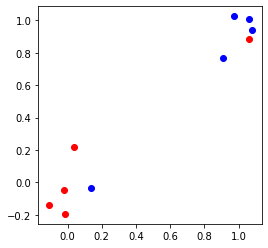

In [7]:
plot_cluster(data, final_model.clusters[0], final_model.clusters[1])